# Quantum Facial Expression Recognition

Facial Expression Recognition (FER) is an extremely relevant task associated with human-computer interaction, with applications in predictive environments, content analysis, support for healthcare, behavioural description and many more. FER is a classification problem consisting in associating a face image with a category of expressions indicating anger, fear, surprise, sadness, happiness and so on.
This is a challenging problem when solved via computer models, due to the heterogeneity of human faces and the variety of poses and background. 
The conventional approach to FER is based on three major steps: image preprocessing, feature extraction, and expression classification.
We describe here how a supervised classifier for expressions can be implemented on a quantum computer. The first preliminary step of image pre-processing is a classical task producing the items in the dataset, while the feature extraction phase is a mapping of such pre-processed images into graphs. The classification step is the quantum part of our implementation, where the features are mapped into the amplitudes of the quantum state forming the input to the quantum circuit representing the image classifier.

In our approach we take a subset of a dataset of pictures (for our experiments we have considered the FFHQ dataset [2]) and label the items in this subset. Then we encode the labelled instances and an unlabelled test instance into quantum states; these are then used as input to a quantum circuit in order to infer the test label. The circuit operates in a way that is similar to the nearest centroid technique [5] of classical machine learning, since the inferred label corresponds to the label of the closest item in terms of the Euclidean distance on a representation of the graphs [3]. The quantum classifier we describe below extends the work in [4]. As we will show later, the output obtained via the final measurement of this circuit can be seen as the minimization of a specific cost function expressing the distance of the unlabelled test from each class of labels, respectively. Thus, by interpreting the distance measure as a kernel, this model can be seen as a kernelized binary classifier. 

The complexity (in terms of number of operations or gates) of the procedure we use to calculate the distance is linear in the number of qubits, while in general a classical procedure would use a number of instructions, which is linear in the number of features. 

## Import the dependencies

In [1]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
import matplotlib.tri as plttri

from qiskit import *
from qiskit.extensions import Initialize

import itertools
import random

# The task

We have to design a program that given image containing either an HAPPY (human) face or a SAD face, provides the correct emotion associated with such image. 

The task can be divided in the following phases:
1. *image preprocessing*: we perform the *facial landmark detection* [1], a process that extract the position of 68 landmark point (you can see this point on the picture below, on some abstract face). The output of this process is the set of coordinates of deformed points. 

![image](images/cloud_of_points.jpg)

2. *feature extraction*: we extract a list of features from this cloud of points. The feature will be the distances between any two couple of points.
3. *classification*: we categorize the feature array associated with our image as HAPPY or SAD. 

# The dataset & the image preprocessing

In order to complete this tutorial we need a set of pictures of faces. You can use your own photos, or you can use the ones attached in `datasets/FFHQ` folder. The folder contains photos from the FFHQ dataset [2], freely downloadable [here](https://github.com/NVlabs/ffhq-dataset). 

Each picture is under Creative Commons BY 2.0, Creative Commons BY-NC 2.0, Public Domain Mark 1.0, Public Domain CC0 1.0, or U.S. Government Works license. All of these licenses allow free use, redistribution, and adaptation for non-commercial purposes. 

The operation of *image preprocessing*, which consists only in the *facial landmark detection*, is performed classically and is not relevant to our purpose. FFHQ dataset already contains the 68 landmark point per picture.

Sub-folders `datasets/FFHQ/happy` and `datasets/FFHQ/sad` contains each 10 images and landmark points, in files named as `xxxxx.png` and `xxxxx_landmarks.json`. Since the dataset does not contain the the emotion associated with the pictures, the latter were labelled manually. 

To load the dataset run the following command:

In [2]:
def load_images_in_folder(folder, label):
    """load all the images (file ending with .png) within the given folder. Expects the image filename is a five digits code
    'xxxxx' and that the file 'xxxxx_landmarks.json' exists within the same folder. Return a structure containing for each image:
    the path of the image, the given label, the set of landmark points."""
    container = []
    # get a list of all files ending with '.png' within the given folder
    images = filter(lambda f: f.endswith('.png'), os.listdir(folder))
    # for each png file:
    for filename in images:
        # get the id, which is the filename without extension
        id = os.path.splitext(filename)[0]
        # calculate the path of the corrisponding landmark points file
        landmarks_path = "{}/{:05d}_landmarks.json".format(folder, int(id))
        # add the current item into the container
        container.append({
            "image": "{}/{}".format(folder, filename),
            "label": label,
            "landmarks": json.load(open(landmarks_path))
        })
    return container

faces_dataset = []
faces_dataset += load_images_in_folder("datasets/FFHQ/happy", "happy")
faces_dataset += load_images_in_folder("datasets/FFHQ/sad", "sad")

You can visualize an a picture and its landmark points using the following method:

In [3]:
def visualize_image(face):

    image = pltimg.imread(face["image"])
    x, y = zip(*face["landmarks"]) # divide the list of (x,y) tuple in the list of x's and y's

    plt.figure(figsize=(8, 6), dpi=80) # set width of figure
    plt.imshow(image) # show image
    plt.scatter(x, y, color='red') # overlay the landmark points in red over the image
    plt.show() # show picture

An happy face:

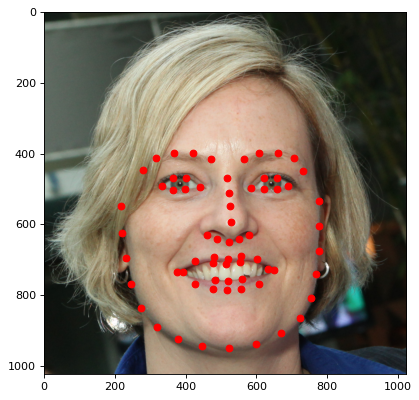

In [4]:
visualize_image(faces_dataset[3])

A sad face:

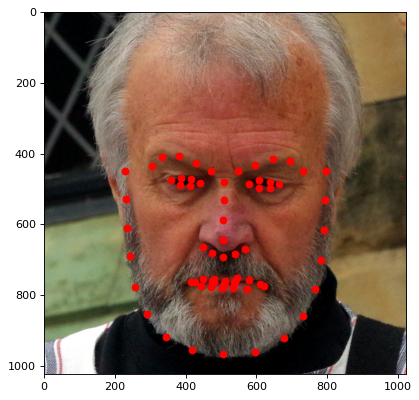

In [5]:
visualize_image(faces_dataset[13])

## From set of coordinates to feature vectors

The set of landmark points representing the face is encoded through an undirected weighted graph. Each graph has 68 vertices, one per landmark point. The edge between two vertices is labelled with the Euclidean distance within the coordinates associated with the vertices. It is possible to add as many edges we like to the graph: the more edges we add, the richer (and possibly redundant) our graph is and the more expensive its encoding in the quantum circuit. We suggest two encodings:
* complete graph encoding: each pair of vertices has an edge between them;
* chordal graph encoding: the graph is chordal and built with the Delaunay triangulation algorithm, which assures that each vertex has at least two edges and every induced cycle in the graph has exactly three vertices.

In [6]:
def build_complete_graph(the_coordinates):
    """Given a list of N items in form (x,y), return the N*N matrix representing 
    the weighted undirected graph whose vertices are the points, an edge exists 
    between each couple of points and is labelled with the distance between them"""
    N = len(the_coordinates) # find the number of coordinates
    graph = np.zeros((N,N))  # create an N*N matrix initializated to zero
    # for each couple of points calculate the distance:
    for i, point_i in enumerate(the_coordinates):
        for j, point_j in enumerate(the_coordinates):
            distance = np.linalg.norm(np.asarray(point_i) - np.asarray(point_j))
            graph[i][j] = distance
            graph[j][i] = distance
    return graph

def build_chordal_graph(the_coordinates):
    """Given a list of N items in form (x,y), return the N*N matrix representing 
    the weighted undirected graph whose vertices are the points, an edge exists 
    between the couple of points decided by the Delaunay triangulation procedure, 
    and is labelled with the distance between them"""
    N = len(the_coordinates)            # find the number of coordinates
    graph = np.zeros((N,N))             # create an N*N matrix initializated to zero
    x, y = zip(*the_coordinates)        # split (x,y) into array of x's and array of y's
    triang = plttri.Triangulation(x, y) # calculate Delaunay triangulation
    # for each edge decided by the Delaunay triangulation procedure:
    for edge in triang.edges:
        i, j = edge[0], edge[1]
        point_i, point_j = the_coordinates[i], the_coordinates[j]
        distance = np.linalg.norm(np.asarray(point_i) - np.asarray(point_j))
        graph[i][j] = distance
        graph[j][i] = distance
    return graph


Now that we have a graph we can construct its adjacency matrix. Since this matrix is symmetric and its diagonal is zero, we consider only the upper triangular part without the diagonal.

In [7]:
def pick_upper_triangular_wo_diagonal(matrix):
    """Given an N*N matrix, return a vector of (N-1)*(N-2) elements containing the items of the input matrix in the upper triangular without diagonal positions"""
    N, _ = matrix.shape
    return matrix[np.triu_indices(N, k=1)] # k=1 removes the diagonal

## The Classifier

The classifier receives in input the vector $x_\text{test}$ and two vectors $x_0, x_1$ which are representatives of the happy and sad faces, respectively. We first compute the Euclidean distances $\mathrm{distance}(x_\text{test}, x_0)$ and $\mathrm{distance}(x_\text{test}, x_1)$. With these distances, we can classify the test item as the closest representative, i.e. the one whose distance from the test item is smaller than from the other representative. 

This extremely simple classifier depends heavily on the choice of the two representatives. However, we will see that this approach gives satisfactory results. Moreover, the accuracy of this classifier can be  improved by calling the `classifier` function multiple times, with different representatives, and classify the test instances with the most frequently occurring label. 

### Classical calculation of the distance function

In order to compare the quantum clasifier with its calssical counterpart, we calculate the distance classically and return the inferred label. 

In [8]:
def classical_distance(G_happy, G_sad, G_test, tol=0.00001):
    """Receives in input the three instances as numpy array of equal length, optionally a tolerance 
    for equality operation and outputs 
    HAPPY if happy_instance is closer to test_instance than to sad_instance else
    SAD if happy_instance is further from test_instance than from sad_instance else 
    EQUAL if happy_instance and sad_instance are equally distant by test_instance"""
    
    # distance between the test instance and the happy instance
    distance_happy = np.linalg.norm(G_happy - G_test)
    
    # distance between the test instance and the sad instance
    distance_sad = np.linalg.norm(G_sad - G_test)
    
    # the difference is = 0 if the distance is equal, > 0 if sad is closest, < 0 if happy is closest
    difference = distance_happy - distance_sad
    
    # remove some numerical error that can classify numbers like +-0.00001 as Y1 or Y0 instead of EQUALS
    the_difference = 0 if np.abs(difference) <= tol else difference
    
    # sign(difference) = 0 -> EQUAL; sign(difference) = 1 -> SAD; sign(difference) = -1 -> HAPPY
    return difference, ["EQUAL", "SAD", "HAPPY"][int(np.sign(the_difference))]

### Quantum calculation of the distance: auxiliary functions

It is convenient to define two auxiliary functions manipulating arrays. 

The first function is used to add zero's to our array so as to fit the size of the quantum register that will contain our data. Any quantum register of $m$ qubits contains exactly $2^m$ coefficients. This means that an array of $n$ elements requires at least $m = \lceil \log_2 n \rceil$ qubits where the last $2^m - n$ coefficients are zero. Given some array and the number $m$ of qubits, the `zero_padding` function adds the necessary zero coefficients and returns a new, zero-padded array. 

In [9]:
def zero_padding(vector, qubits):
    """Given a complex vector of size n, adds up zeros until size 2**qubits is reached"""
    zeros = np.zeros((2**qubits,), dtype=np.cdouble)
    zeros[:len(vector)] = vector
    return zeros

Any quantum register containing an array must have norm one. The `normalize` method normalizes the array. 

In [10]:
def normalize(vector):
    """Return the normalized input vector"""
    max_iter = 10
    while np.linalg.norm(vector) != 1.0 and max_iter > 0:
        vector = vector / np.linalg.norm(vector)
        max_iter -= 1
    return vector

Finally, we need a procedure that encodes our data. To this purpose we use the [`Initialize`](https://qiskit.org/documentation/stubs/qiskit.extensions.Initialize.html) gate. Note that `Initialize` consists of a row of non-linear `Reset` gates, one per each qubit, resetting the qubits to $|0\rangle$, followed by the unitary transformation that encodes our data. `Initialize` can be very inefficient and the speed of the algorithm is dependent on it being efficient. 

To implement the quantum classifier circuit we will need the controlled version of `Initialize` gates. It can be calculated automatically by calling the `control` method (the only parameter is the desired number of control qubits). However, `control` only works with linear circuits so we need to find a way to remove the leading `Reset` gates.

The simplest way currently available is:
1. create the `Initialize` gate;
2. call the `gates_to_uncompute` method that invert the circuit and also removes the `Reset` gates;
3. call the `invert` method to invert again, we have now the initialization without resets;
4. call `control` method. 

In [11]:
def controlled_initialize(normalized_vector, control_qubits):
    # create the circuit for initialization with leading Reset gates
    initialize_circuit = Initialize(normalized_vector)
    # gates_to_uncompute inverts the circuit, removing the Reset gates
    # and by inverting again we obtain the initialization circuit w/o Reset
    initialize_circuit_wo_reset = initialize_circuit.gates_to_uncompute().inverse()
    # return controlled version of the gate
    return initialize_circuit_wo_reset.control(control_qubits)

### Quantum calculation of the distance: the circuit

The distance function calculation is obtained by the circuit below.

The imput to the circuit is composed by four registers:
* the first, single qubit register $|a\rangle$ is called auxiliary register;
* the second register $|i\rangle$ is the index register;
* the third register $|d\rangle$ is the data register;
* the fourth register $|c\rangle$ is class register.

![image](images/facial_expression_recognition_circuit.png) 

Given a feature vector $G = [g_1, ..., g_d]$ representing the graph, we can build the quantum state $|G\rangle = \frac{1}{\gamma}\sum_{i=1}^d g_i |i\rangle$ where $\gamma = \sqrt{\sum_{i=1}^d |g_k|^2}$ is the normalization factor. 


The circuit evolves as follows:
1. the circuit starts in state:
$$|0\rangle_a |0\rangle_i |0\rangle_d |0\rangle_c;$$
2. after the first two Hadamard gates the state is:
$$\frac{1}{2} (|0\rangle+|1\rangle)_a (|0\rangle+|1\rangle)_i |0\rangle_d |0\rangle_c$$
so that both the auxiliary and the index registers are in an uniform superposition;
3. after the controlled initialization of the test instance the state is: 
$$\frac{1}{2} |0\rangle_a (|0\rangle+|1\rangle)_i |0\rangle_d |0\rangle_c + \frac{1}{2} |1\rangle_a (|0\rangle+|1\rangle)_i |G_\text{test}\rangle_d |0\rangle_c;$$
4. after the X operation on the auxiliary qubit the state is:
$$\frac{1}{2} |0\rangle_a (|0\rangle+|1\rangle)_i |G_\text{test}\rangle_d |0\rangle_c + \frac{1}{2} |1\rangle_a (|0\rangle+|1\rangle)_i |0\rangle_d |0\rangle_c;$$
the data $G_\text{test}$ is now bond with auxiliary $0$, and this will allow us to interfere this data with $G_1$ and $G_2$ later;
5. after the double-controlled initialization of the first representative the state is:
$$\frac{1}{2} |0\rangle_a (|0\rangle+|1\rangle)_i |G_\text{test}\rangle_d |0\rangle_c + \frac{1}{2} |1\rangle_a |0\rangle_i |0\rangle_d |0\rangle_c + \frac{1}{2} |1\rangle_a |1\rangle_i |G_0\rangle_d |0\rangle_c;$$
6. after the X operation on the index register the state is:
$$\frac{1}{2} |0\rangle_a (|0\rangle+|1\rangle)_i |G_\text{test}\rangle_d |0\rangle_c + \frac{1}{2} |1\rangle_a |0\rangle_i |G_0\rangle_d |0\rangle_c + \frac{1}{2} |1\rangle_a |1\rangle_i |0\rangle_d |0\rangle_c;$$
the data $G_1$ is now bond with auxiliary $1$ and index $0$, 
7. after the double-controlled initialization of the second representative the state is:
$$\frac{1}{2} |0\rangle_a (|0\rangle+|1\rangle)_i |G_\text{test}\rangle_d |0\rangle_c + \frac{1}{2} |1\rangle_a |0\rangle_i |G_0\rangle_d |0\rangle_c + \frac{1}{2} |1\rangle_a |1\rangle_i |G_1\rangle_d |0\rangle_c;$$
the data $G_2$ is now bond with auxiliary $1$ and index $1$, 
8. after the CNOT gate binding the index register with the class register, the state is:
$$\frac{1}{2} |0\rangle_a |0\rangle_i |G_\text{test}\rangle_d |0\rangle_c + \frac{1}{2} |0\rangle_a |1\rangle_i |G_\text{test}\rangle_d |1\rangle_c + \frac{1}{2} |1\rangle_a |0\rangle_i |G_0\rangle_d |0\rangle_c + \frac{1}{2} |1\rangle_a |1\rangle_i |G_1\rangle_d |1\rangle_c;$$
for the sake of visualization, we set $|0\rangle_c$ as $|y_0\rangle_c$ and $|1\rangle_c$ as $|y_1\rangle_c$ to remind us that such register contains the two labels:
$$\frac{1}{2} |0\rangle_a |0\rangle_i |G_\text{test}\rangle_d |y_0\rangle_c + \frac{1}{2} |0\rangle_a |1\rangle_i |G_\text{test}\rangle_d |y_1\rangle_c + \frac{1}{2} |1\rangle_a |0\rangle_i |G_0\rangle_d |y_0\rangle_c + \frac{1}{2} |1\rangle_a |1\rangle_i |G_1\rangle_d |y_1\rangle_c;$$
which is re-arranged into the following equation:
$$ \frac{1}{2} \sum_{k \in \{0, 1\}} \Big( |0\rangle_a |G_\text{test}\rangle_d + |1\rangle_a |G_k\rangle_d  \Big) |k\rangle_i |y_k\rangle_c;$$
this operation bonds index $0$ with class $y_0$ and index $1$ with class $y_1$;
9. after the final Hadamard gate the state is:
$$\frac{1}{2\sqrt{2}} \sum_{k \in \{0, 1\}} \Big( |0\rangle_a (|G_\text{test}\rangle + |G_k\rangle)_d + |1\rangle_a (|G_\text{test}\rangle - |G_k\rangle)_d \Big) |k\rangle_i |y_k\rangle_c;$$
this operation interfere the data $G_\text{test}$ with $G_1, G_2$, allowing us to calculate the distances.   

In [12]:
def quantum_distance_circuit(G_happy, G_sad, G_test):
    """Create the quantum circuit for classification"""
    # calculate how many qubits are needed for the data register
    qubit_per_feature = int(np.ceil(np.log2(len(G_happy))))
    # zero padding and normalization
    x_0 = normalize(zero_padding(G_happy, qubit_per_feature))
    x_1 = normalize(zero_padding(G_sad, qubit_per_feature))
    x_test = normalize(zero_padding(G_test, qubit_per_feature))
    # define the registers
    qr_auxiliary = QuantumRegister(1, 'anc')
    qr_index = QuantumRegister(1, 'index')
    qr_data = QuantumRegister(qubit_per_feature, 'data')
    qr_class = QuantumRegister(1, 'class')
    cr_auxiliary = ClassicalRegister(1, 'cr_anc')
    cr_class = ClassicalRegister(1, 'cr_class')
    # initialize the circuit
    qc = QuantumCircuit(qr_auxiliary, qr_index, qr_data, qr_class, cr_auxiliary, cr_class)
    # initialize index and data registers
    qc.h([0, 1])
    qc.append(controlled_initialize(x_test, 1), [qr_auxiliary[0]] + qr_data[:])
    qc.x(0)
    qc.append(controlled_initialize(x_0, 2), [qr_auxiliary[0], qr_index[0]] + qr_data[:])
    qc.x(1)
    qc.append(controlled_initialize(x_1, 2), [qr_auxiliary[0], qr_index[0]] + qr_data[:])
    # correlate the index with the class
    qc.cx(qr_index[0], qr_class[0]) 
    # work on auxiliary
    qc.h(0)
    # measure
    qc.measure(qr_auxiliary[0], cr_auxiliary[0])
    qc.measure(qr_class[0], cr_class[0])
    return qc

### Quantum calculation of the distance: the circuit

We now measure the auxiliary qubit projecting it to the zero state. The circuit will be then in state:
$$\frac{1}{\sqrt{|| G_\text{test} + G_0 ||}} |0\rangle_a |0\rangle_i |G_\text{test} + G_0\rangle_d |y_0\rangle_c + \frac{1}{\sqrt{|| G_\text{test} + G_1 ||}} |0\rangle_a |1\rangle_i |G_\text{test} + G_1\rangle_d |y_1\rangle_c$$
For simmetry reasons, we can equivalently consider the results having auxiliary bit set to one and slightly modify the above formula.

By estimating the probability of reading class $y_0=0$ or $y_1=1$ we can estimate the distance between $G_\text{test}, G_0$ with respect to the distance between $G_\text{test}, G_1$. So, 
$$y_\text{test} = \begin{cases}     y_0,           & > .5 \\     y_1,           & < .5 \\     \text{equals}, & = .5 \end{cases}$$
To mitigate the errors due to the probabilistic nature of the computation, we can introduce a small tolerance $\epsilon$ around the boundary between the two distances:
$$y_\text{test} = \begin{cases}     y_0, & > .5+\epsilon \\     y_1, & < .5-\epsilon \\     \text{equals}, & \text{otherwise} \end{cases}$$

It is simple to see that, once the data is loaded, the part of circuit that calculates the distance has a constant number of operations and therefore its complexity is $O(1)$, while any classical algorithm needs $O(n)$ steps, where $n$ is the number of components of the vectors. 

In [13]:
def quantum_distance(G_happy, G_sad, G_test, tol=0.00001, backend=None):
    """Creates the quantum circuit, runs it and return the difference between the two distances and the expected label"""
    SHOTS = 10000
    qc = quantum_distance_circuit(G_happy, G_sad, G_test)
    # custom backend
    if backend is None:
        backend = Aer.get_backend('qasm_simulator')
    counts = execute(qc, backend, shots=SHOTS).result().get_counts()
    # add missing values
    keys = ['0 0', '0 1', '1 0', '1 1'] # LSB = auxiliary, MSB = Class
    for key in keys:
        if key not in counts:
            counts[key] = 0
    # calculate distance
    keep_auxiliary_zero = False # you can equivalently keep results having auxiliary = 0 or auxiliary = 1
    if keep_auxiliary_zero:
        distance_happy = counts['1 0']
        distance_sad   = counts['0 0']
    else:
        distance_happy = counts['0 1']
        distance_sad   = counts['1 1']
    difference = (distance_happy - distance_sad)/SHOTS
    the_difference = 0 if np.abs(difference) <= tol else difference
    return difference, ["EQUAL", "SAD", "HAPPY"][int(np.sign(the_difference))]

## Image Classification

We can use the above classifier to solve the FER problem ([3]). 

For the sake of simplicity, we consider only a subset of the points of the faces. This allows us to reduce the amount of information encoded within the quantum circuit. In particular, we can consider only the points related to the mouth under the assumption that a smily mouth is related to happyness emotion and a sulky mouth is related to sadness emotion. 

It is interesting to study  the accuracy changes when we further limit the number of points of the mouth considered for the classification. For tis reason we define the `pick_mouth_points` function which randomly generates a subset of $n$ vertices within 48 and 68, without repetitions.

In [14]:
def pick_mouth_points(n_points):
    """Returns a numpy array containing 'n_points' numbers between 48 and 68-1 without repetitions, given 0 <= n_points <= 20."""
    MOUTH_START, MOUTH_END = 48, 68
    return np.sort(np.random.choice(range(MOUTH_START, MOUTH_END), n_points, replace=False))

Finally the method `faces_classifier` receives ad input the three faces `happy_instance`, `sad_instance`, `test_instance` which are list of coordinates (loaded from the dataset using `load_landmarks`) and some configuration parameters:
* `is_quantum` is true for `quantum_distance` and false for `classical_distance`;
* `is_complete_graph`is true for `build_complete_graph` technique and false for `build_complete_graph`;
* `n_points` must be an integer between 1 and 20 representing how many randomly chosen points of the mouth consider for the classification.

The output is either the string `HAPPY` or `SAD`. 

In [15]:
def faces_classifier(happy_instance, sad_instance, test_instance, is_quantum=True, is_complete_graph=True, n_points=20, backend=None):
    
    # pick construction method
    construction_method = build_complete_graph if is_complete_graph else build_complete_graph
    
    # choose points
    chosen_points  = pick_mouth_points(n_points)
    happy_instance = np.array(happy_instance["landmarks"])[chosen_points]
    sad_instance   = np.array(sad_instance["landmarks"])[chosen_points]
    test_instance  = np.array(test_instance["landmarks"])[chosen_points]
    
    # calculate features
    feature_happy = pick_upper_triangular_wo_diagonal(construction_method(happy_instance))
    feature_sad = pick_upper_triangular_wo_diagonal(construction_method(sad_instance))
    feature_test = pick_upper_triangular_wo_diagonal(construction_method(test_instance))
    
    # classify
    if is_quantum:
        distance, label = quantum_distance(feature_happy, feature_sad, feature_test, backend=backend)
    else:
        distance, label = classical_distance(feature_happy, feature_sad, feature_test)
        
    return label

In order to check the accuracy we can partition the dataset in training set and testing set:

In [17]:
happy_dataset = load_images_in_folder("datasets/FFHQ/happy", "HAPPY")
sad_dataset   = load_images_in_folder("datasets/FFHQ/sad", "SAD")

N_TRAINING_ITEMS = 5
happy_training_set = happy_dataset[:N_TRAINING_ITEMS]
sad_training_set   = sad_dataset[:N_TRAINING_ITEMS]

happy_testing_set = happy_dataset[N_TRAINING_ITEMS:]
sad_testing_set   = sad_dataset[N_TRAINING_ITEMS:]
testing_set       = happy_testing_set + sad_testing_set

Finally we calculate the accuracy:

In [18]:
n_points          = 15 # from 1 to 20
is_complete_graph = True
is_quantum        = False

correct, wrong = 0, 0
for test_instance in testing_set:
    
    happy_instance = random.choice(happy_training_set)
    sad_instance   = random.choice(sad_training_set)
    
    label = faces_classifier(happy_instance, sad_instance, test_instance, 
                             is_quantum=is_quantum, 
                             is_complete_graph=is_complete_graph, 
                             n_points=n_points)
    
    if label == test_instance["label"]:
        correct += 1
        print(".", end="")
    else:
        wrong += 1
        print("X", end="")

print(f"\nWe have classified {correct} faces correctly and {wrong} faces wrongly")

.......X..
We have classified 9 faces correctly and 1 faces wrongly


Clearly, the accuracy for both the quantum and the classical case heavily depends on the choice of the two representatives. The accuracy might be improved by classifying the test instance by calling the faces classifier multiple times, with different representatives, and assigning the most frequently occurring label. 


In [19]:
def most_common(lst):
    return max(set(lst), key=lst.count)

Finally, run the classification multiple times per item:

In [20]:
n_points          = 15 # from 1 to 20
is_complete_graph = True
is_quantum        = True
CLASSIFICATION_PER_ITEM = 3

correct, wrong = 0, 0
for test_instance in testing_set:
    
    labels = []
    for _ in range(CLASSIFICATION_PER_ITEM):
        happy_instance = random.choice(happy_training_set)
        sad_instance   = random.choice(sad_training_set)
        label = faces_classifier(happy_instance, sad_instance, test_instance, 
                                 is_quantum=is_quantum, 
                                 is_complete_graph=is_complete_graph, 
                                 n_points=n_points)
        labels.append(label)
    
    label = most_common(labels)
    
    if label == test_instance["label"]:
        correct += 1
        print(".", end="")
    else:
        wrong += 1
        print("X", end="")

print(f"\nWe have classified {correct} faces correctly and {wrong} faces wrongly")

.....X..XX
We have classified 7 faces correctly and 3 faces wrongly


## References 

[1] Facial Landmark Detection, [https://paperswithcode.com/task/facial-landmark-detection](https://paperswithcode.com/task/facial-landmark-detection).

[2] A Style-Based Generator Architecture for Generative Adversarial Networks, Tero Karras (NVIDIA), Samuli Laine (NVIDIA), Timo Aila (NVIDIA), [http://stylegan.xyz/paper](http://stylegan.xyz/paper).

[3] Facial Expression Recognition on a Quantum Computer (2021, DOI 10.1007/s42484-020-00035-5), R. Mengoni, M. Incudini, A. Di Pierro.

[4] Implementing a distance-based classifier with a quantum interference circuit (2017, DOI 10.1209/0295-5075/119/60002), M. Schuld, M. Fingerhuth, F. Petruccione.

[5] [Nearest centroid classifier](https://en.wikipedia.org/wiki/Nearest_centroid_classifier)